# CDC Diabetes Dataset Analysis

This notebook analyzes the CDC Diabetes Health Indicators dataset to create an interpretable prediction model with explanations for healthcare workers.

## 1. Setup and Imports

In [74]:
import sys
import os
sys.path.append(os.path.abspath('../'))

import pandas as pd
import matplotlib.pyplot as plt
import warnings
import json
from pathlib import Path

from scripts.utils import *

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

MODEL_DIR = "../models"
MODEL_NAME = "cdc_diabetes"
FORCE_RETRAIN = False  # Set to True to force retraining of all models

Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

## 2. Load CDC Diabetes Dataset

In [75]:
cdc_df = load_dataset("../data/cdc_dataset.csv", dataset_type="cdc")
cdc_df.head()

Loaded cdc dataset with shape: (253680, 22)


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,diabetes
0,1,1,1,40,1,0,0,0,0,1,0,1,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,0,0,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,0,1,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,0,1,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,0,1,0,2,3,0,0,0,11,5,4,0


### Data Description

The CDC Diabetes Health Indicators dataset contains responses from the CDC's Behavioral Risk Factor Surveillance System (BRFSS). Key variables include:

- **HighBP**: High blood pressure status (0 = no, 1 = yes)
- **HighChol**: High cholesterol status (0 = no, 1 = yes)
- **BMI**: Body Mass Index
- **Smoker**: Smoking status (0 = no, 1 = yes)
- **PhysActivity**: Physical activity in past 30 days (0 = no, 1 = yes)
- **Fruits**: Fruit consumption 1+ times per day (0 = no, 1 = yes)
- **Veggies**: Vegetable consumption 1+ times per day (0 = no, 1 = yes)
- **HvyAlcoholConsump**: Heavy alcohol consumption (0 = no, 1 = yes)
- **GenHlth**: General health (1 = excellent to 5 = poor)
- **MentHlth**: Days of poor mental health in past 30 days
- **PhysHlth**: Days of poor physical health in past 30 days
- **DiffWalk**: Difficulty walking or climbing stairs (0 = no, 1 = yes)
- **Age**: Age in categories (1 = 18-24, 9 = 60-64, 13 = 80+)
- **Education**: Education level (1 = never attended, 6 = 4+ years college)
- **Income**: Income level (1 = < $10k, 8 = $75k+)
- **diabetes**: Diabetes status (0 = no, 1 = yes, the target variable)

## 3. Exploratory Data Analysis (EDA)

Dataset shape: (253680, 22)

--- Basic Statistics ---
              HighBP       HighChol      CholCheck            BMI  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.429001       0.424121       0.962670      28.382364   
std         0.494934       0.494210       0.189571       6.608694   
min         0.000000       0.000000       0.000000      12.000000   
25%         0.000000       0.000000       1.000000      24.000000   
50%         0.000000       0.000000       1.000000      27.000000   
75%         1.000000       1.000000       1.000000      31.000000   
max         1.000000       1.000000       1.000000      98.000000   

              Smoker         Stroke  HeartDiseaseorAttack   PhysActivity  \
count  253680.000000  253680.000000         253680.000000  253680.000000   
mean        0.443169       0.040571              0.094186       0.756544   
std         0.496761       0.197294              0.292087       0.429169   
min         0.000000

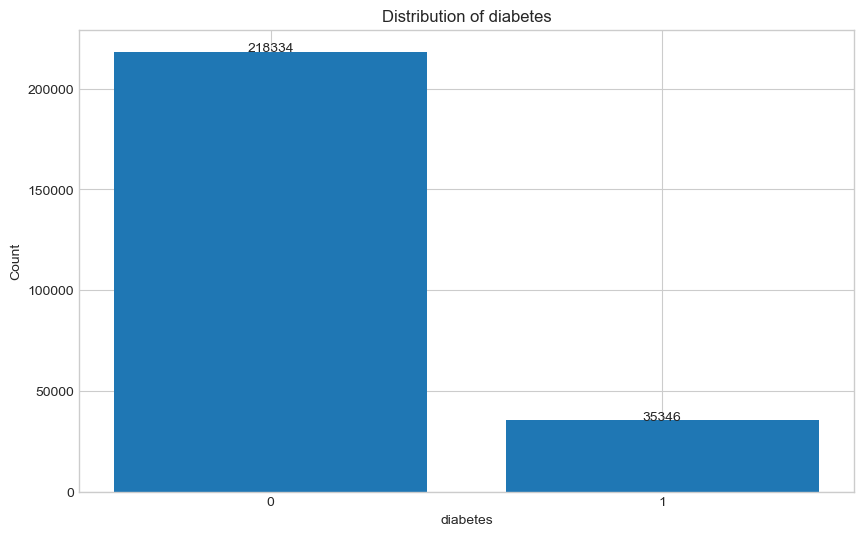


Class imbalance ratio: 6.18:1


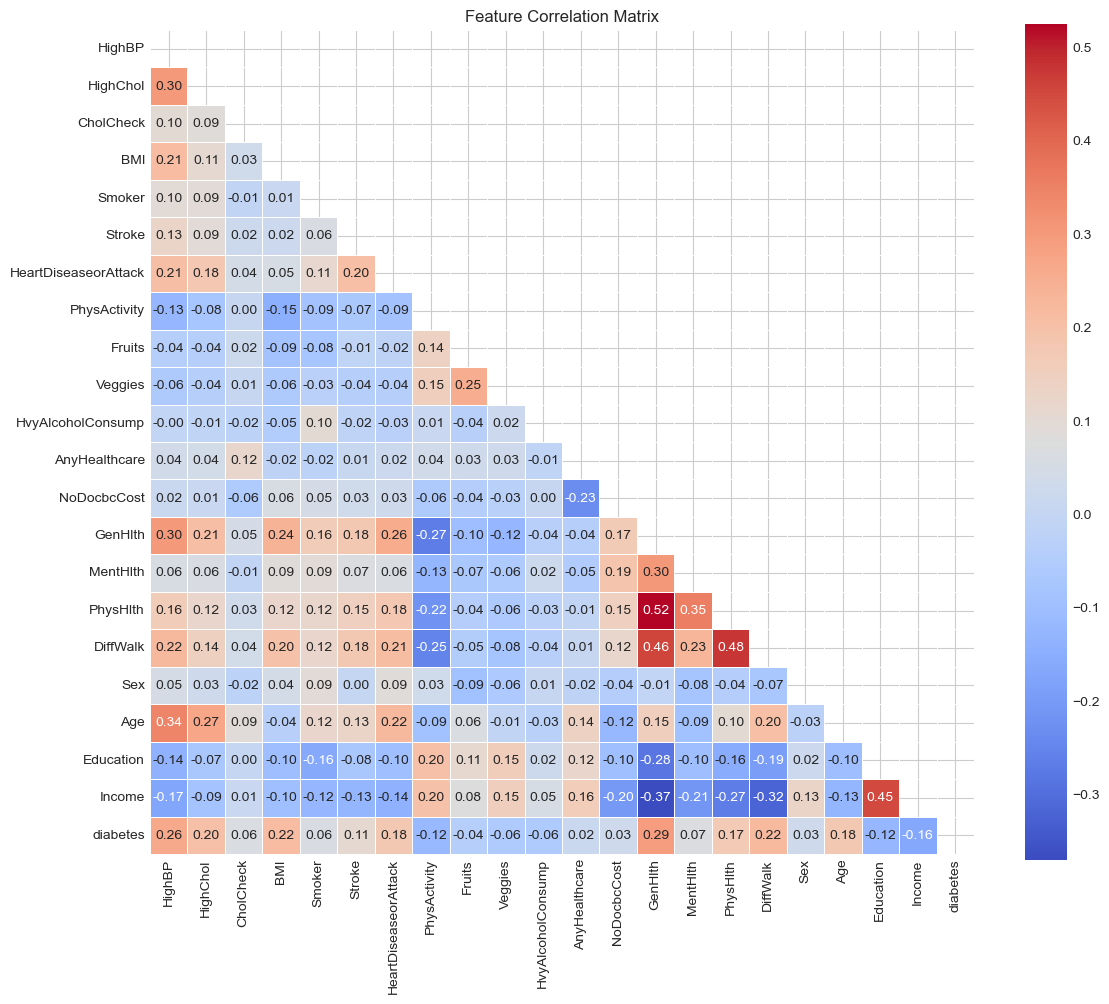

In [76]:
perform_eda(cdc_df, target='diabetes')

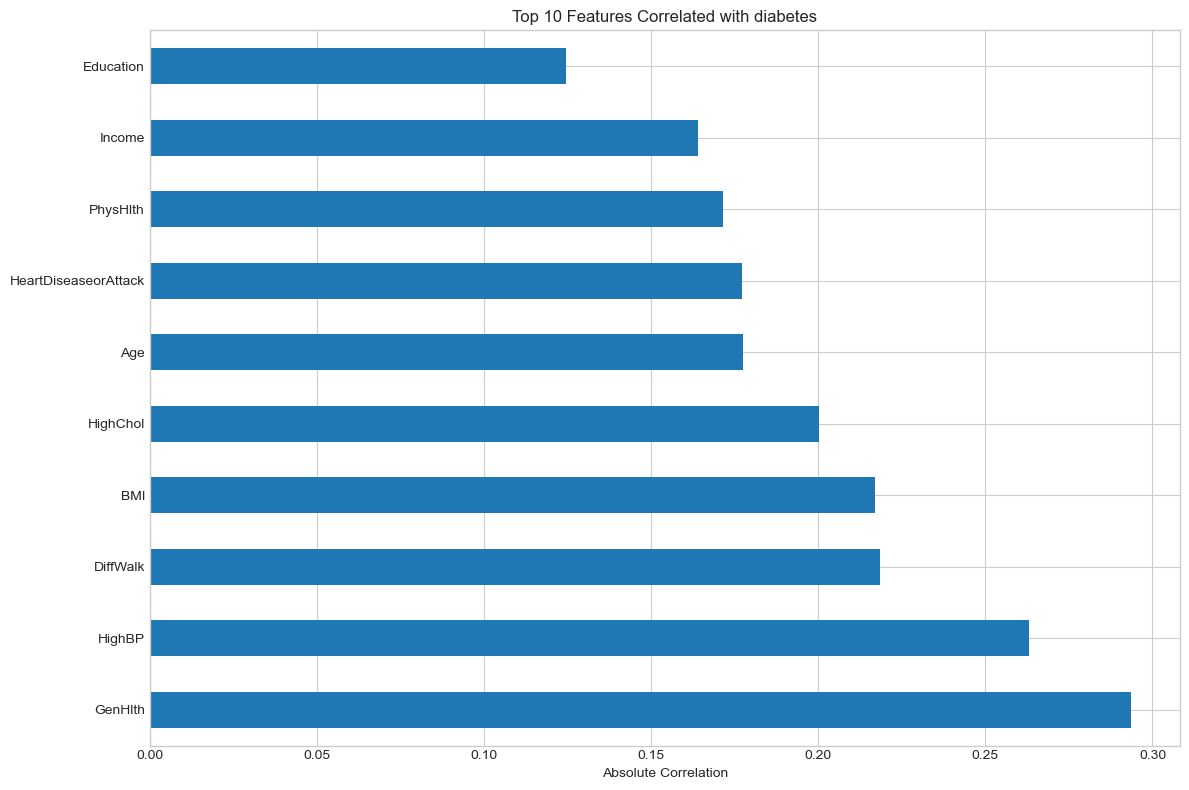

In [77]:
plot_feature_importance_to_target(cdc_df, target='diabetes', top_n=10)

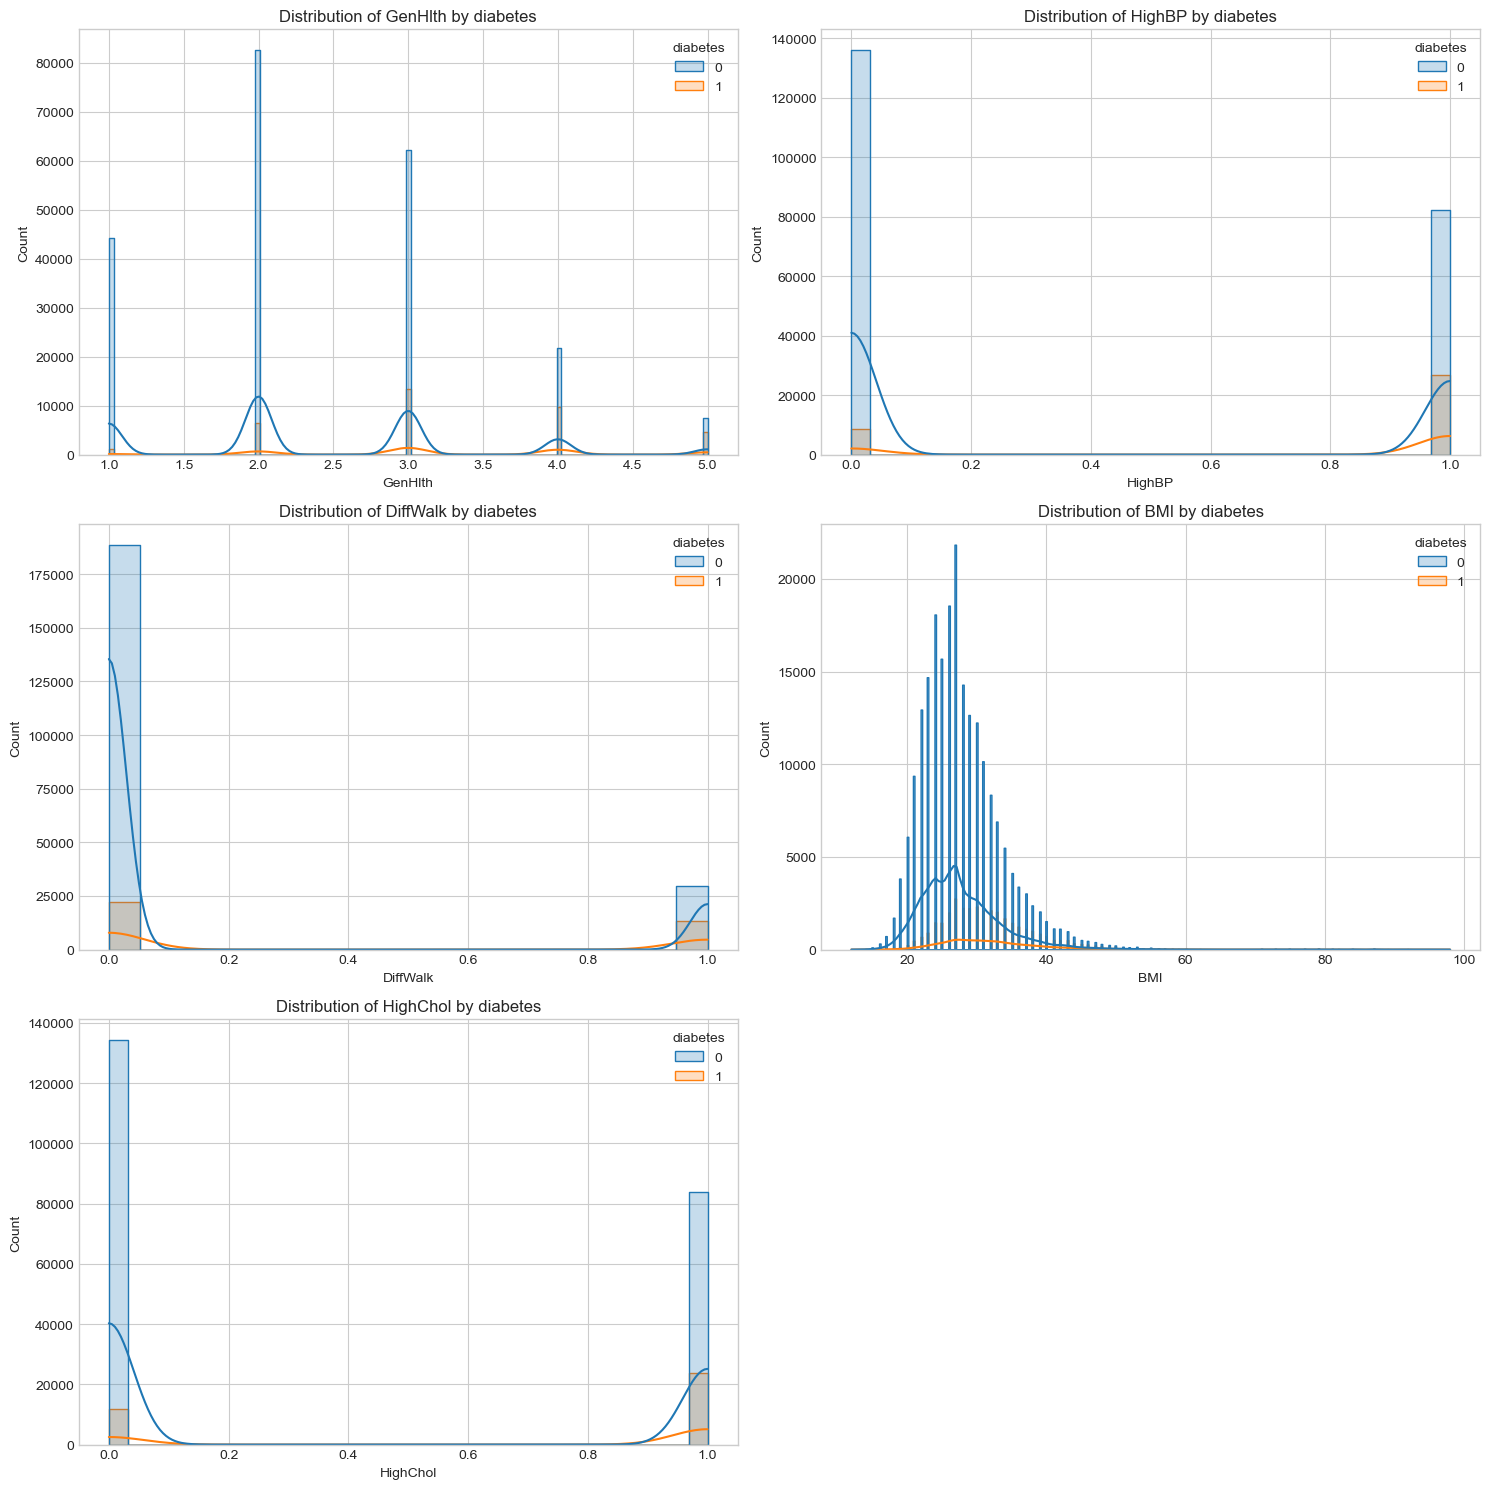

In [78]:
numeric_cols = cdc_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('diabetes')
correlations = cdc_df[numeric_cols].corrwith(cdc_df['diabetes']).abs().sort_values(ascending=False)
top_numeric_features = correlations.head(5).index.tolist()

plot_distributions_by_target(cdc_df, target='diabetes', num_features=top_numeric_features)

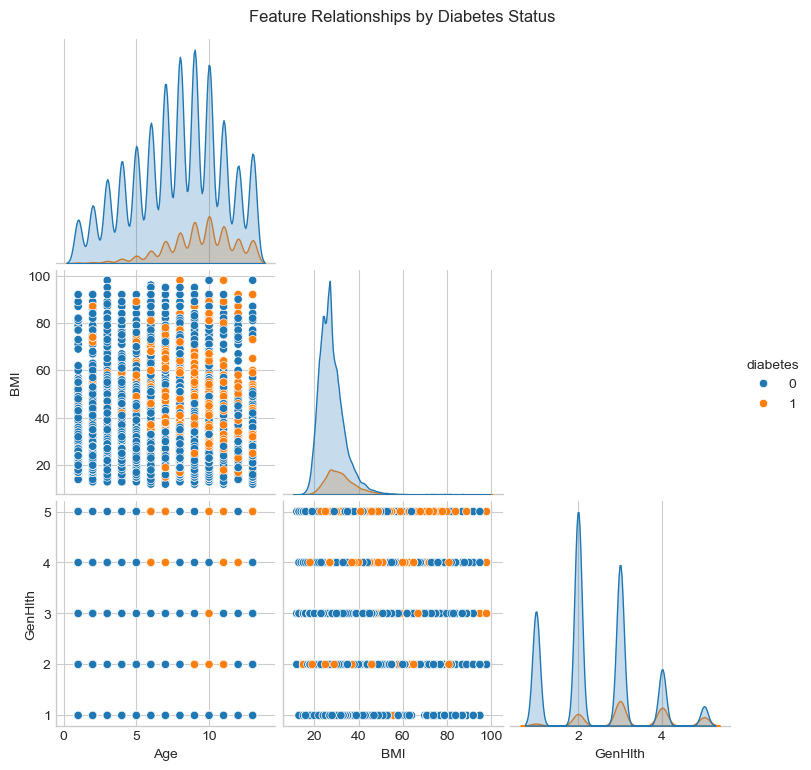

In [79]:
create_feature_pairplot(cdc_df, target='diabetes', features=['Age', 'BMI', 'GenHlth'])

## 4. Data Preprocessing

In [80]:
X = cdc_df.drop('diabetes', axis=1)
y = cdc_df['diabetes']

X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=42, stratify=y)

Splitting data with test_size=0.2
Training set: (202944, 21), Test set: (50736, 21)
Class distribution in training set: {np.int64(0): np.int64(174667), np.int64(1): np.int64(28277)}
Class distribution in test set: {np.int64(0): np.int64(43667), np.int64(1): np.int64(7069)}


In [81]:
preprocessor_path = Path(MODEL_DIR) / f"{MODEL_NAME}_preprocessor.pkl"
if preprocessor_path.exists() and not FORCE_RETRAIN:
    print(f"Loading existing preprocessor from {preprocessor_path}...")
    preprocessor = joblib.load(preprocessor_path)
    feature_info_path = Path(MODEL_DIR) / f"{MODEL_NAME}_feature_info.pkl"
    with open(feature_info_path, 'rb') as f:
        feature_info = pickle.load(f)
    num_features = feature_info['num_features']
    cat_features = feature_info['cat_features']
    feature_names = feature_info['feature_names']
else:
    print("Building and fitting preprocessor...")
    preprocessor, num_features, cat_features = build_preprocessing_pipeline(X)
    X_train_processed = preprocessor.fit_transform(X_train)
    feature_names = get_feature_names(preprocessor, num_features, cat_features)
    
    joblib.dump(preprocessor, preprocessor_path)
    feature_info = {
        'feature_names': feature_names,
        'num_features': num_features,
        'cat_features': cat_features
    }
    with open(Path(MODEL_DIR) / f"{MODEL_NAME}_feature_info.pkl", 'wb') as f:
        pickle.dump(feature_info, f)

X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Total processed features: {len(feature_names)}")

Loading existing preprocessor from ..\models\cdc_diabetes_preprocessor.pkl...
Total processed features: 21


## 5. Model Training and Evaluation


=== Decision Tree Model ===
Loading existing decision_tree model from ..\models\cdc_diabetes_decision_tree_model.pkl...
Model loaded successfully!


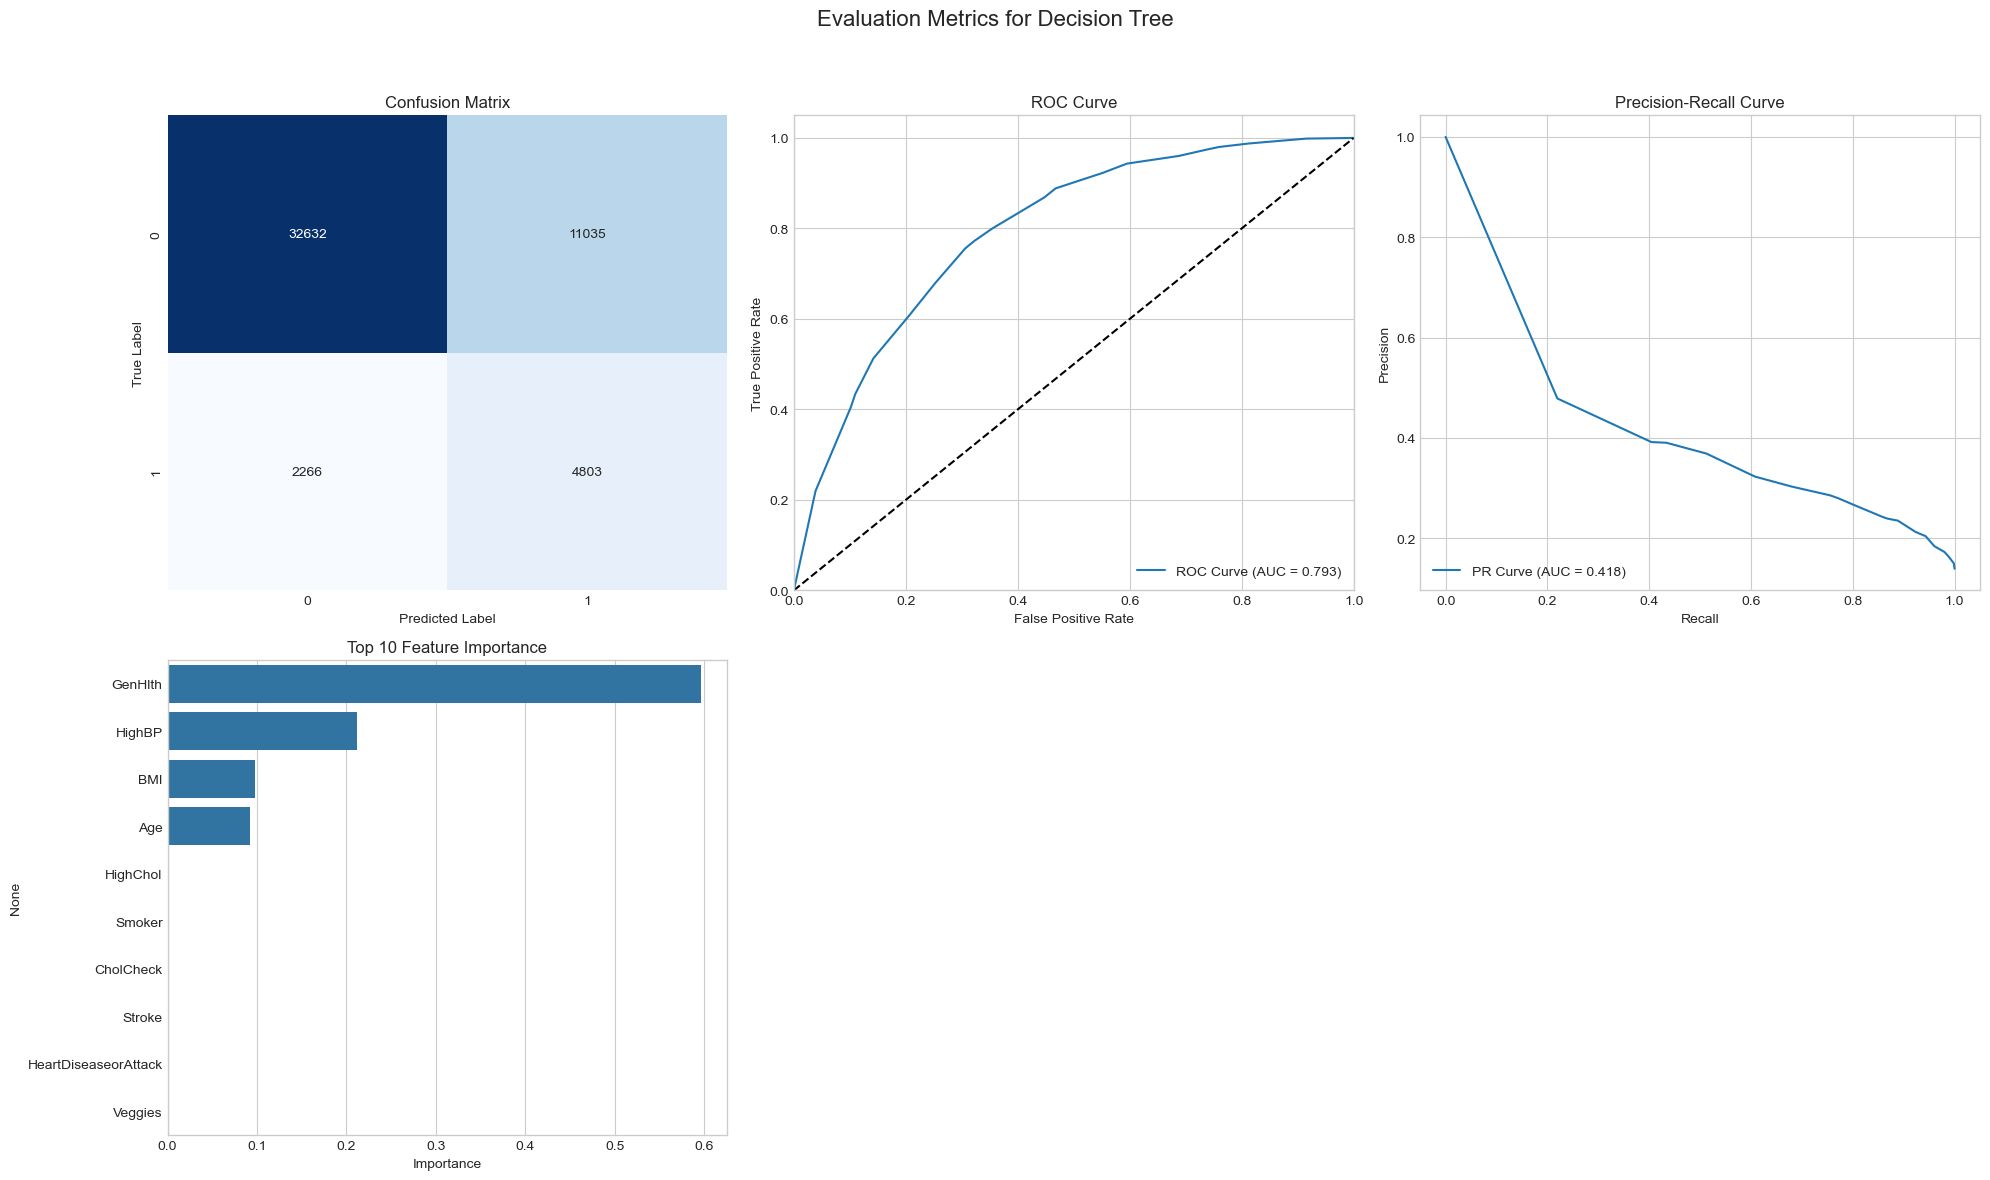


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83     43667
           1       0.30      0.68      0.42      7069

    accuracy                           0.74     50736
   macro avg       0.62      0.71      0.63     50736
weighted avg       0.85      0.74      0.77     50736


=== Random Forest Model ===
Loading existing random_forest model from ..\models\cdc_diabetes_random_forest_model.pkl...
Model loaded successfully!


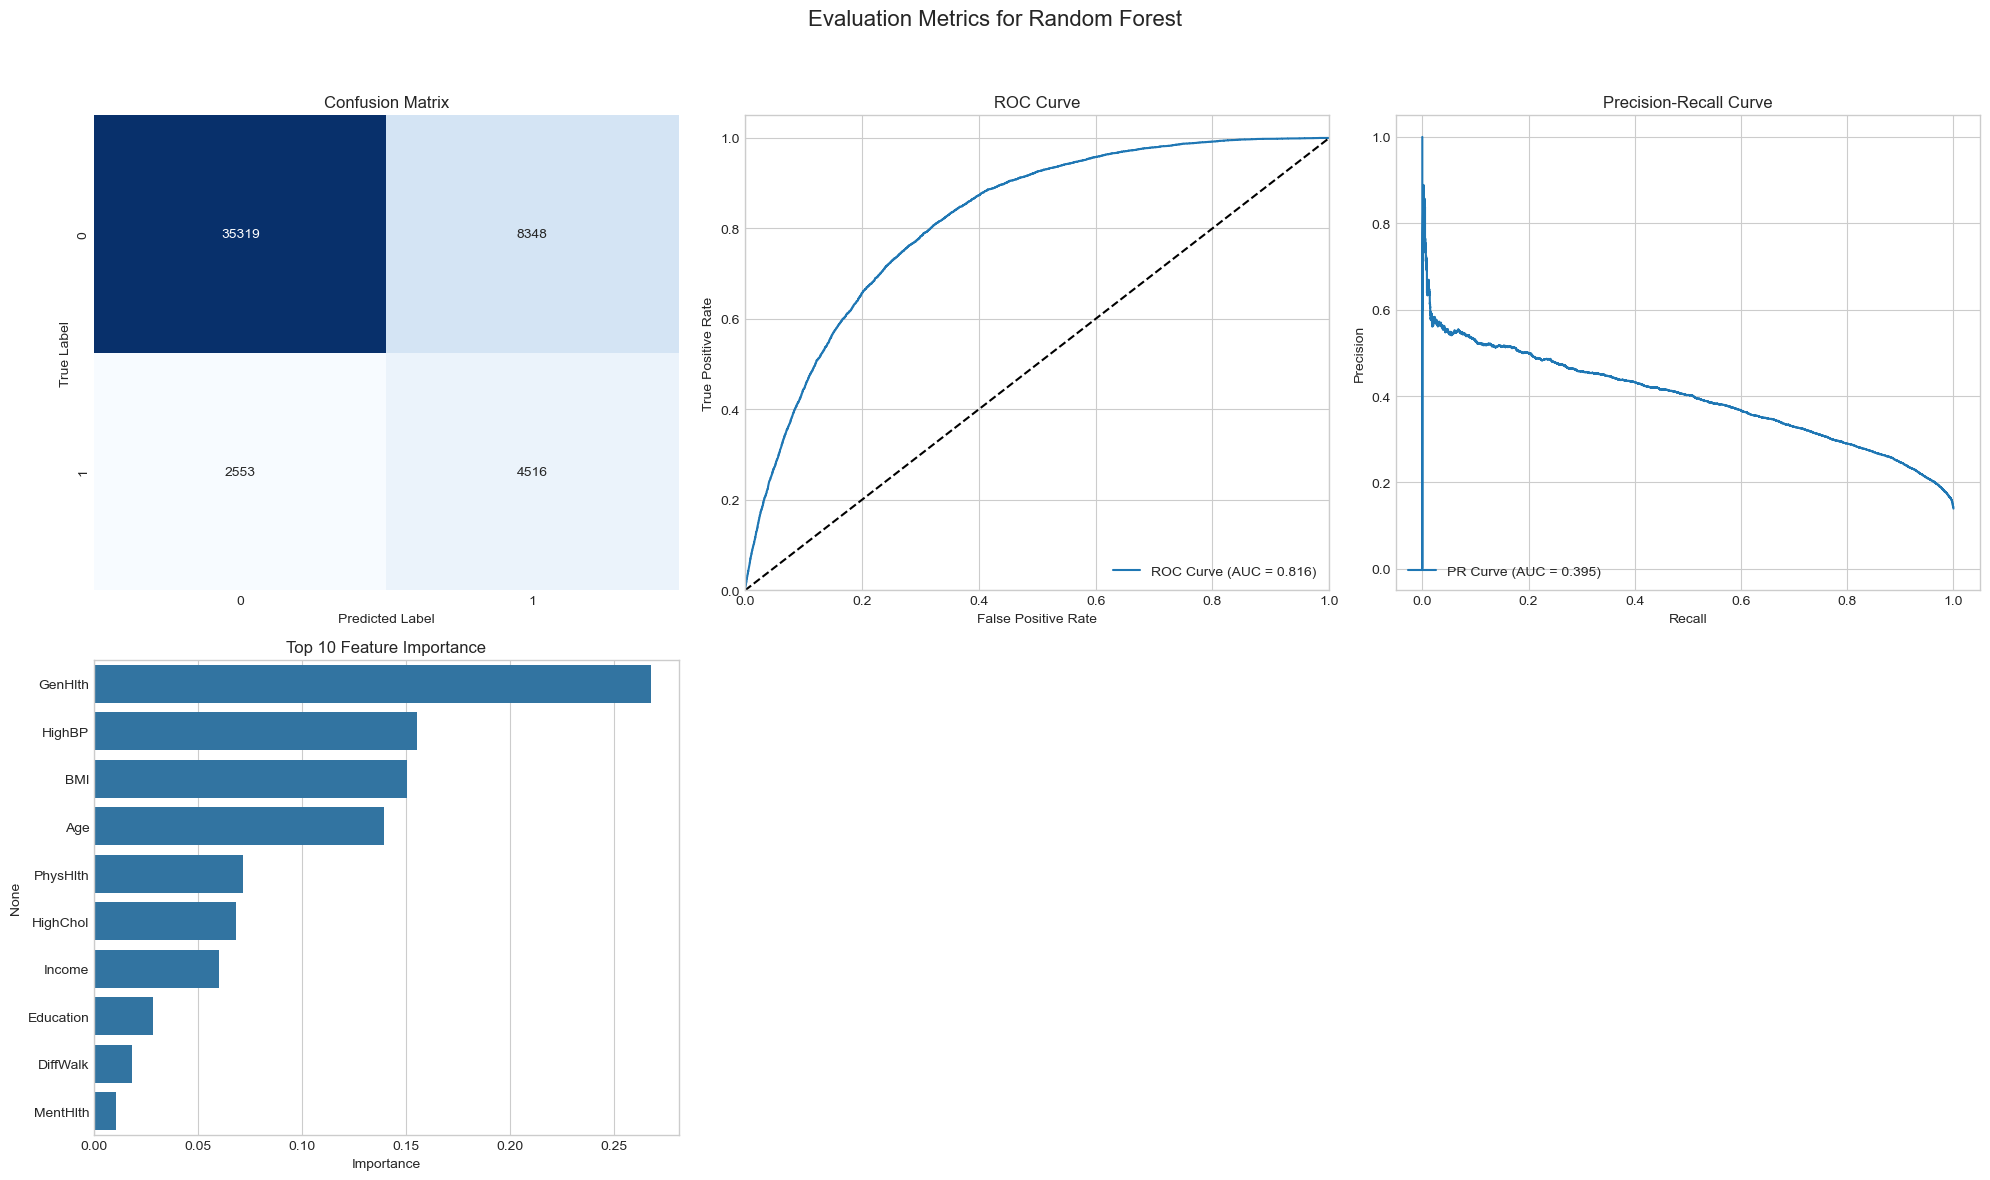


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87     43667
           1       0.35      0.64      0.45      7069

    accuracy                           0.79     50736
   macro avg       0.64      0.72      0.66     50736
weighted avg       0.85      0.79      0.81     50736


=== XGBoost Model ===
Loading existing xgboost model from ..\models\cdc_diabetes_xgboost_model.pkl...
Model loaded successfully!


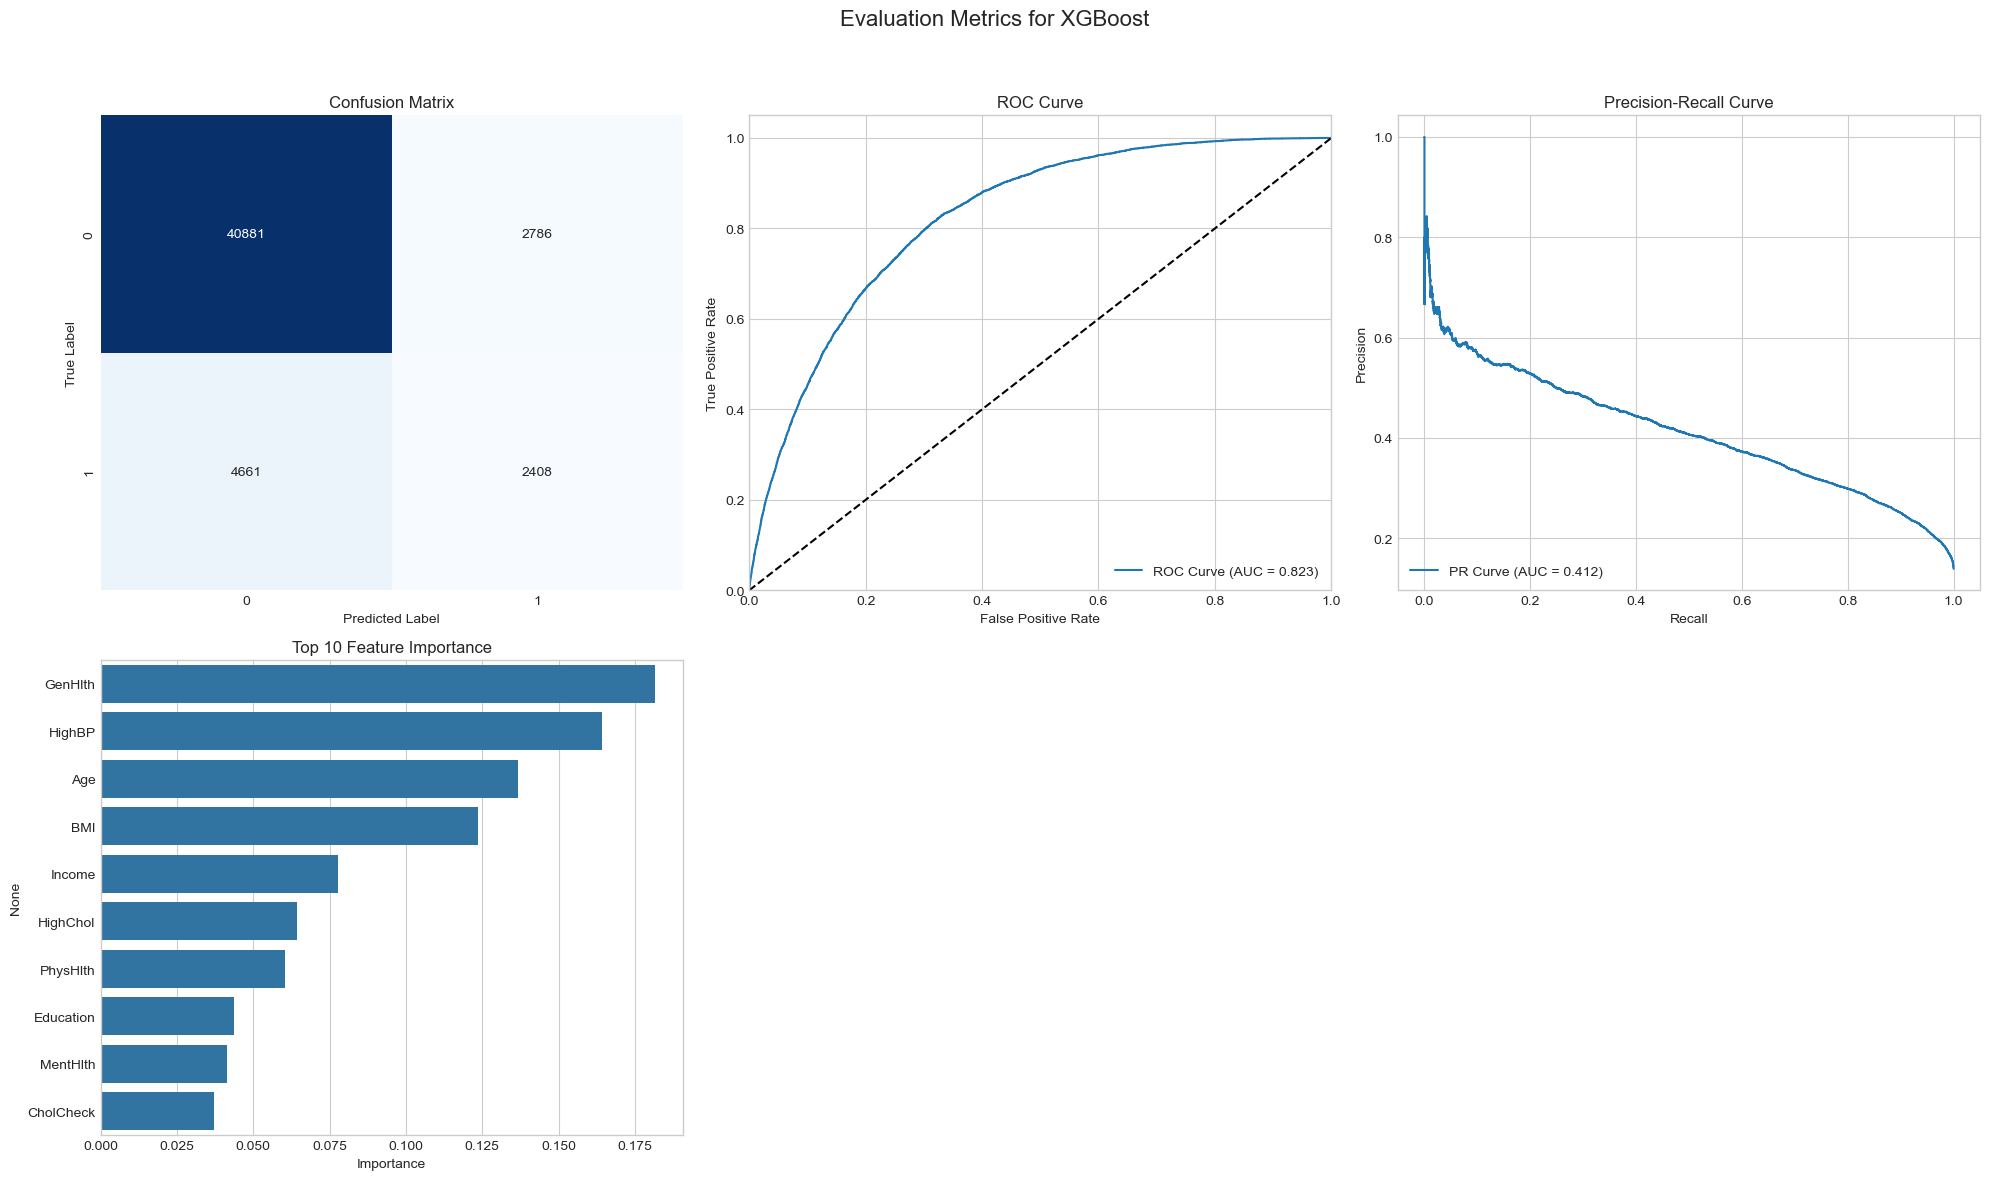


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     43667
           1       0.46      0.34      0.39      7069

    accuracy                           0.85     50736
   macro avg       0.68      0.64      0.65     50736
weighted avg       0.84      0.85      0.84     50736



In [82]:
model_results = {}

# Decision Tree (highest interpretability)
print("\n=== Decision Tree Model ===")
dt_model = train_or_load_model(
    X_train_processed, y_train, 
    model_type='decision_tree', 
    balance_method='smote',
    model_dir=MODEL_DIR,
    model_name=MODEL_NAME,
    force_retrain=FORCE_RETRAIN
)
dt_evaluation = evaluate_model(dt_model, X_test_processed, y_test, feature_names)
plot_evaluation_results(dt_evaluation, "Decision Tree")
model_results['decision_tree'] = {'model': dt_model, 'evaluation': dt_evaluation}

# Random Forest (balanced approach)
print("\n=== Random Forest Model ===")
rf_model = train_or_load_model(
    X_train_processed, y_train, 
    model_type='random_forest', 
    balance_method='smote',
    model_dir=MODEL_DIR,
    model_name=MODEL_NAME,
    force_retrain=FORCE_RETRAIN
)
rf_evaluation = evaluate_model(rf_model, X_test_processed, y_test, feature_names)
plot_evaluation_results(rf_evaluation, "Random Forest")
model_results['random_forest'] = {'model': rf_model, 'evaluation': rf_evaluation}

# XGBoost (highest performance)
print("\n=== XGBoost Model ===")
xgb_model = train_or_load_model(
    X_train_processed, y_train, 
    model_type='xgboost', 
    balance_method='smote',
    model_dir=MODEL_DIR,
    model_name=MODEL_NAME,
    force_retrain=FORCE_RETRAIN
)
xgb_evaluation = evaluate_model(xgb_model, X_test_processed, y_test, feature_names)
plot_evaluation_results(xgb_evaluation, "XGBoost")
model_results['xgboost'] = {'model': xgb_model, 'evaluation': xgb_evaluation}

In [83]:
performance_df = pd.DataFrame(columns=['Model', 'ROC AUC', 'PR AUC'])

for model_name, results in model_results.items():
    performance_df = performance_df._append({
        'Model': model_name,
        'ROC AUC': results['evaluation']['roc_auc'],
        'PR AUC': results['evaluation']['pr_auc']
    }, ignore_index=True)

performance_df = performance_df.sort_values('ROC AUC', ascending=False).reset_index(drop=True)
performance_df

,Model,ROC AUC,PR AUC
0,xgboost,0.822551,0.411579
1,random_forest,0.816498,0.394724
2,decision_tree,0.793044,0.418362


In [84]:
best_model_name = performance_df.iloc[0]['Model']
best_model = model_results[best_model_name]['model']
best_evaluation = model_results[best_model_name]['evaluation']

print(f"Best model: {best_model_name}")
print(f"ROC AUC: {best_evaluation['roc_auc']:.4f}")
print(f"PR AUC: {best_evaluation['pr_auc']:.4f}")

model_metadata = {
    'best_model': best_model_name,
    'model_comparison': performance_df.to_dict(orient='records'),
    'timestamp': pd.Timestamp.now().isoformat(),
    'best_roc_auc': float(best_evaluation['roc_auc']),
    'best_pr_auc': float(best_evaluation['pr_auc'])
}

with open(Path(MODEL_DIR) / f"{MODEL_NAME}_metadata.json", 'w') as f:
    json.dump(model_metadata, f, indent=4)

Best model: xgboost
ROC AUC: 0.8226
PR AUC: 0.4116


## 6. Model Interpretability with SHAP

In [85]:
explainer, shap_values = generate_shap_explanations(best_model, X_test_processed, feature_names, sample_size=100)

Generating SHAP values for 100 samples...


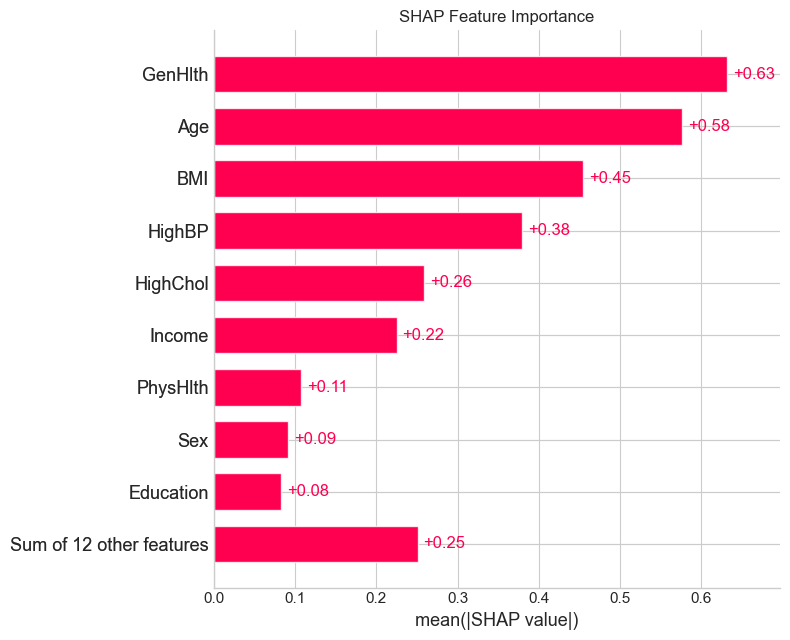

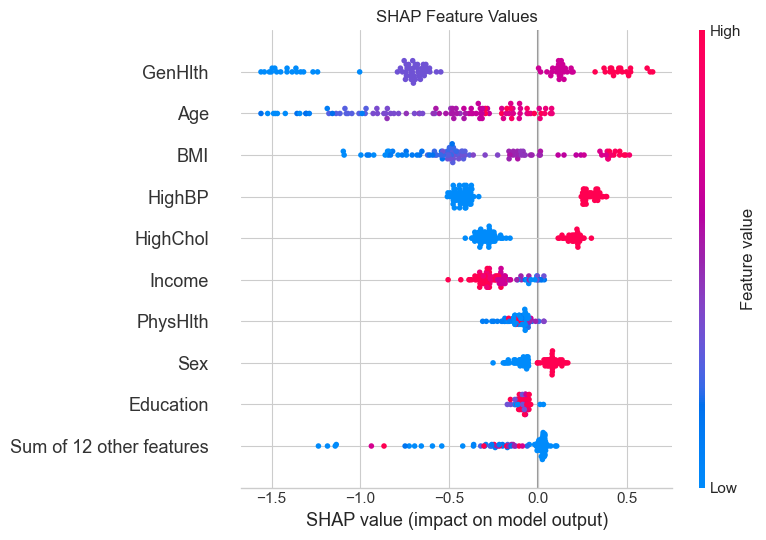

In [86]:
plot_shap_summary(shap_values, feature_names, plot_type="both")

SHAP values shape: (100, 21)
Features shape: (50736, 21)


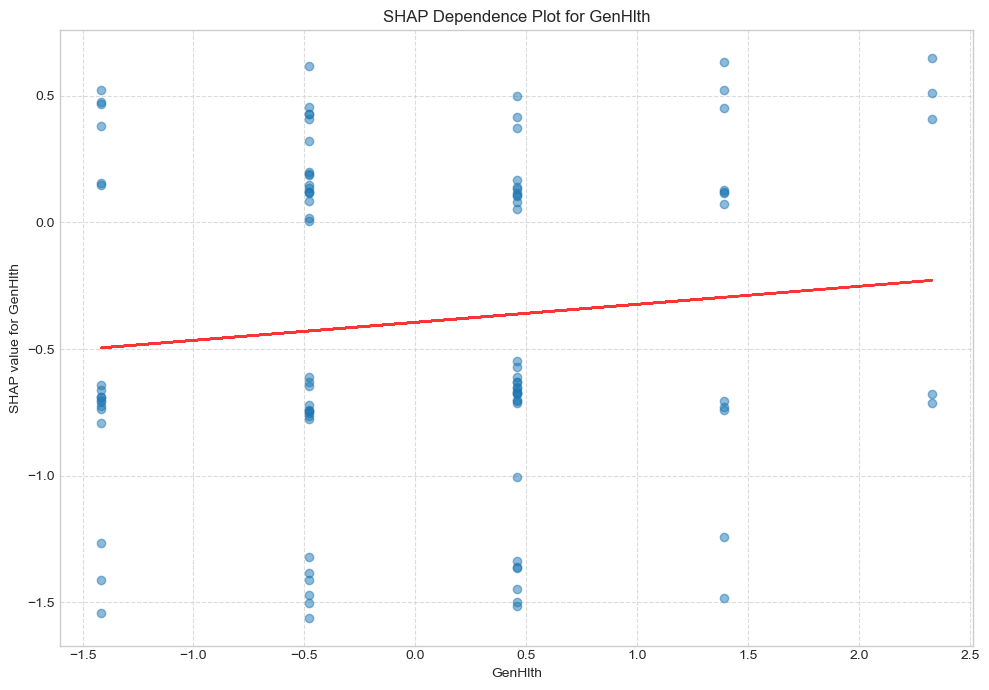

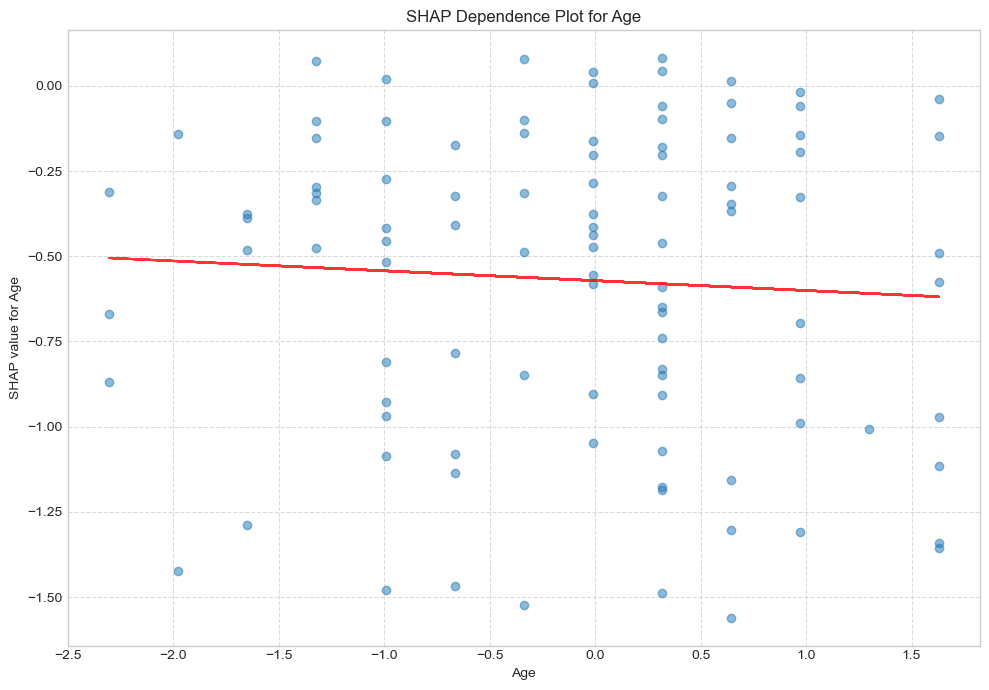

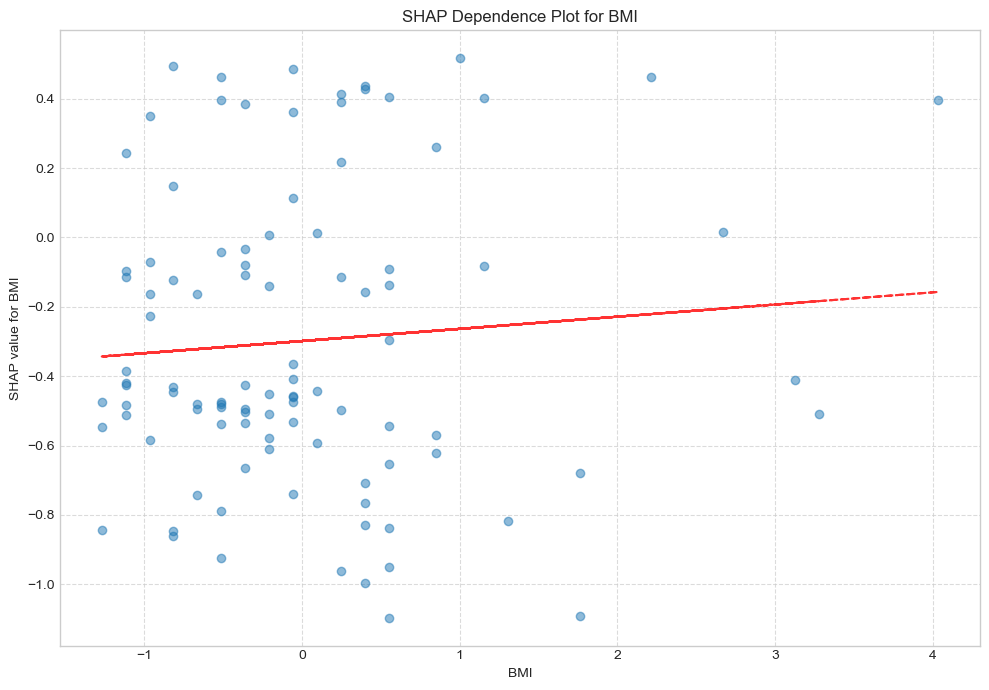

In [87]:
plot_shap_dependence(shap_values, X_test_processed, feature_names, top_n=3)

## 7. Healthcare Worker Dashboard

In [88]:
analyze_patient = create_healthcare_dashboard(
    best_model, preprocessor, feature_names, num_features, cat_features
)

Healthcare Dashboard created. Use analyze_patient() function to analyze patients.


Example Patient Data:
HighBP: 1
HighChol: 1
CholCheck: 1
BMI: 28
Smoker: 0
Stroke: 0
HeartDiseaseorAttack: 0
PhysActivity: 1
Fruits: 1
Veggies: 1
HvyAlcoholConsump: 0
AnyHealthcare: 1
NoDocbcCost: 0
GenHlth: 3
MentHlth: 0
PhysHlth: 0
DiffWalk: 0
Sex: 1
Age: 5
Education: 5
Income: 8
Prediction: Non-Diabetic (Probability: 0.24)
Risk Level: Low


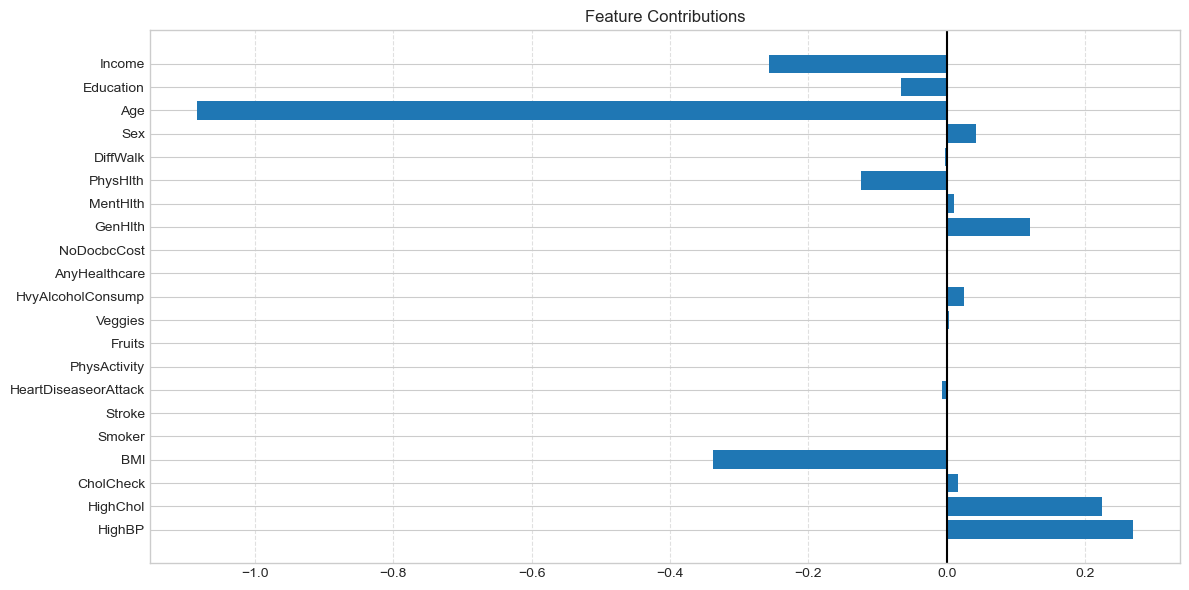


===== Risk Factor Analysis =====

Factors INCREASING diabetes risk:
  - GenHlth: 0.1200 contribution
  - HighChol: 0.2253 contribution
  - HighBP: 0.2699 contribution

Factors DECREASING diabetes risk:
  - Age: -1.0844 contribution
  - BMI: -0.3371 contribution
  - Income: -0.2571 contribution


In [89]:
example_patient = X_test.iloc[[0]].copy()
print("Example Patient Data:")
for col in example_patient.columns:
    print(f"{col}: {example_patient[col].values[0]}")

patient_analysis = analyze_patient(example_patient)

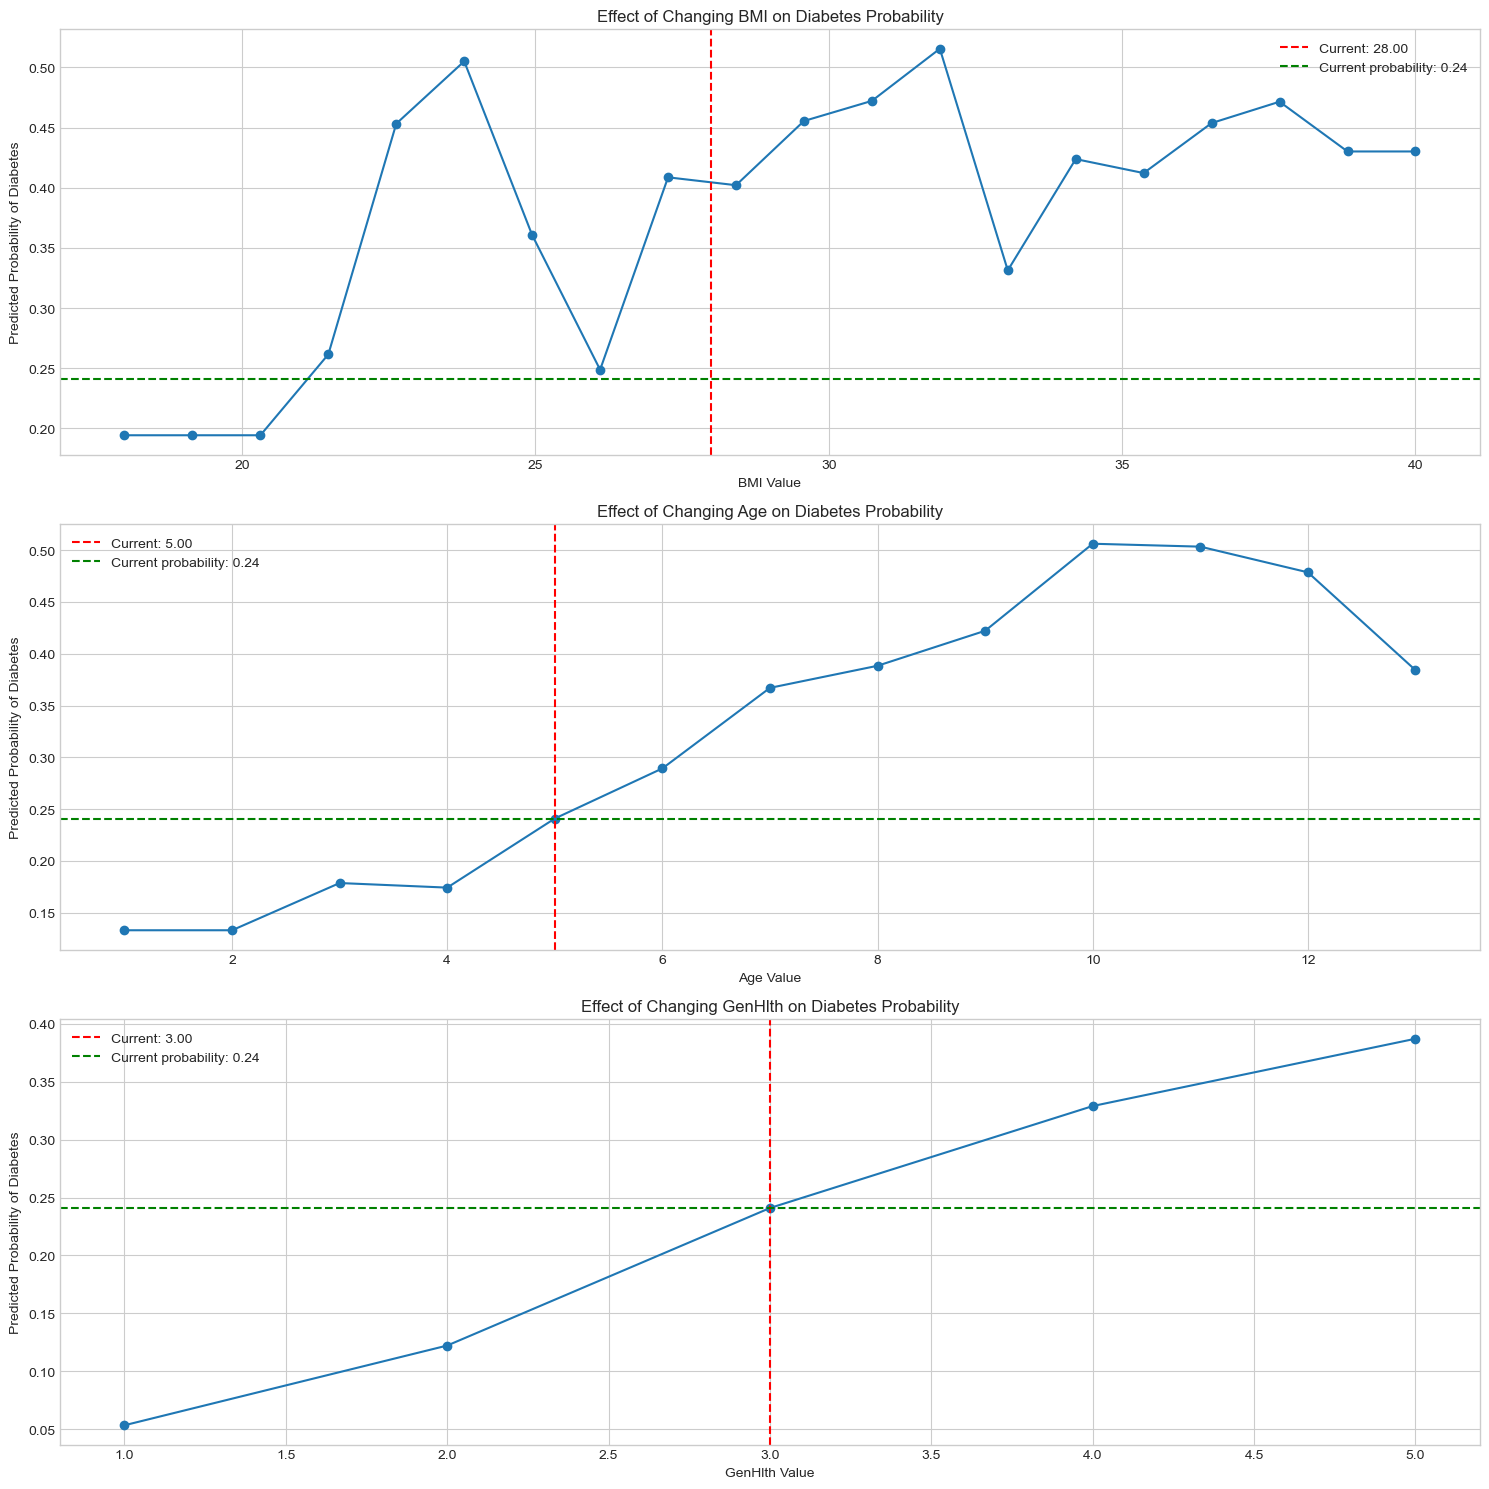

In [90]:
feature_ranges = {
    'BMI': (18, 40, 20),         # Range from 18 to 40 with 20 steps
    'Age': (1, 13, 13),          # Age categories from 1 (18-24) to 13 (80+)
    'GenHlth': (1, 5, 5)         # General health from 1-5 with 5 steps
}

create_what_if_analysis(
    example_patient, best_model, preprocessor, num_features, feature_ranges
)

## 8. Save Model and Artifacts

In [91]:
save_model_artifacts(
    best_model,
    preprocessor,
    feature_names,
    num_features,
    cat_features,
    model_dir=MODEL_DIR,
    model_name=MODEL_NAME,
    model_metadata={
        'best_model': best_model_name,
        'timestamp': pd.Timestamp.now().isoformat(),
        'roc_auc': float(best_evaluation['roc_auc']),
        'pr_auc': float(best_evaluation['pr_auc']),
        'model_comparison': performance_df.to_dict(orient='records')
    }
)

print(f"Model training and evaluation complete. The best model ({best_model_name}) has been saved.")

Model artifacts saved to ..\models
Model training and evaluation complete. The best model (xgboost) has been saved.
